# Exploration 09
---
## 폐렴 진단하기

In [1]:
# 필요한 라이브러리 import
import os, re
import random, math
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import warnings 
warnings.filterwarnings(action='ignore')

In [2]:
# 데이터 로드할 때 빠르게 로드할 수 있도록하는 설정 변수
AUTOTUNE = tf.data.experimental.AUTOTUNE
# X-RAY 이미지 사이즈 변수
IMAGE_SIZE = [180, 180]

# 데이터 경로 변수
ROOT_PATH = os.path.join(os.getenv('HOME'), 'aiffel')
TRAIN_PATH = ROOT_PATH + '/chest_xray/data/train/*/*' # *은 모든 디렉토리와 파일을 의미.
VAL_PATH = ROOT_PATH + '/chest_xray/data/val/*/*'
TEST_PATH = ROOT_PATH + '/chest_xray/data/test/*/*'

# 
BATCH_SIZE = 64
EPOCHS = 32

print(ROOT_PATH)

/aiffel/aiffel


`BATCH_SIZE = 128`, `EPOCHS  = 30` 으로 하여 학습을 진행해보자.

### 데이터 가져오기

In [3]:
train_filenames = tf.io.gfile.glob(TRAIN_PATH)
test_filenames = tf.io.gfile.glob(TEST_PATH)
val_filenames = tf.io.gfile.glob(VAL_PATH)

print('train data 개수 : ', len(train_filenames))
print('test  data 개수 : ', len(test_filenames))
print('val   data 개수 : ', len(val_filenames))

train data 개수 :  5216
test  data 개수 :  624
val   data 개수 :  16


val_data의 개수가 다른 두 데이터에 비해 작으므로 train_data와 val_data 를 합친 후에 8:2 로 분할

In [4]:
# train 데이터와 validation 데이터를 모두 filenames에 담는다.
filenames = tf.io.gfile.glob(TRAIN_PATH)
filenames.extend(tf.io.gfile.glob(VAL_PATH))

# 모아진 filenames를 8:2로 나눈다.
train_size = math.floor(len(filenames)*0.8)
random.seed(8)
random.shuffle(filenames)
train_filenames = filenames[:train_size]
val_filenames = filenames[train_size:]

print('train data 개수 : ', len(train_filenames))
print('val   data 개수 : ', len(val_filenames))

train data 개수 :  4185
val   data 개수 :  1047


In [5]:
print(f'Normal image path\n{filenames[0]}')
print(f'Pneumonia image path\n{filenames[2000]}')

Normal image path
/aiffel/aiffel/chest_xray/data/train/NORMAL/NORMAL2-IM-1317-0001.jpeg
Pneumonia image path
/aiffel/aiffel/chest_xray/data/train/PNEUMONIA/person299_bacteria_1418.jpeg


In [6]:
COUNT_NORMAL = len([filename for filename in train_filenames if "NORMAL" in filename])
print(f"Normal images count in training set: {COUNT_NORMAL}")


COUNT_PNEUMONIA = len([filename for filename in train_filenames if "PNEUMONIA" in filename])
print(f"Pneumonia images count in training set: {COUNT_PNEUMONIA}")

Normal images count in training set: 1072
Pneumonia images count in training set: 3113


정상이미지보다 폐렴 이미지가 3배 정도 더 많이 존재하는 것을 확인할 수 있다. <br>
CNN모델의 경우 데이터의 balance가 좋을 수록 학습이 잘 진행된다. 단, test_data와 val_data의 경우 평가를 위한 데이터이기 때문에 balance가 크게 고려되지 않는다.



In [7]:
train_list_ds = tf.data.Dataset.from_tensor_slices(train_filenames)
val_list_ds = tf.data.Dataset.from_tensor_slices(val_filenames)

In [8]:
TRAIN_IMG_COUNT = tf.data.experimental.cardinality(train_list_ds).numpy()
print(f"Training images count: {TRAIN_IMG_COUNT}")

VAL_IMG_COUNT = tf.data.experimental.cardinality(val_list_ds).numpy()
print(f"Validating images count: {VAL_IMG_COUNT}")

Training images count: 4185
Validating images count: 1047


In [9]:
# 파일 경로의 끝에서 두번째 부분을 확인하면 양성과 음성을 구분할 수 있다.
def get_label(file_path):
    parts = tf.strings.split(file_path, os.path.sep)
    return parts[-2] == "PNEUMONIA"   # 폐렴이면 양성(True), 노말이면 음성(False)

In [10]:
# 이미지를 알맞은 형식으로 바꾸기.
def decode_img(img):
    img = tf.image.decode_jpeg(img, channels=3) # 이미지를 uint8 tensor로 수정
    img = tf.image.convert_image_dtype(img, tf.float32) # float32 타입으로 수정
    img = tf.image.resize(img, IMAGE_SIZE) # 이미지 사이즈를 IMAGE_SIZE로 수정
    return img

# 이미지 파일의 경로를 입력하면 이미지와 라벨을 읽어온다.
def process_path(file_path):
    label = get_label(file_path) # 라벨 검출
    img = tf.io.read_file(file_path) # 이미지 읽기
    img = decode_img(img) # 이미지를 알맞은 형식으로 수정
    return img, label

In [11]:
train_ds = train_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds = val_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)

In [12]:
for image, label in train_ds.take(1):
    print("Image shape: ", image.numpy().shape)
    print("Label: ", label.numpy())

Image shape:  (180, 180, 3)
Label:  False


In [13]:
test_list_ds = tf.data.Dataset.list_files(TEST_PATH)
TEST_IMAGE_COUNT = tf.data.experimental.cardinality(test_list_ds).numpy()
test_ds = test_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
test_ds = test_ds.batch(BATCH_SIZE)

print(TEST_IMAGE_COUNT)

624


In [14]:
def augment(image,label):
    image = tf.image.random_flip_left_right(image)  # 랜덤하게 좌우를 반전.
    return image,label

def prepare_for_training(ds, shuffle_buffer_size=1000):
    # augment 적용 부분이 배치처리 함수에 추가되었음.
    ds = ds.map(
            augment,       # augment 함수 적용
            num_parallel_calls=2
        )
    ds = ds.shuffle(buffer_size=shuffle_buffer_size)
    ds = ds.repeat()
    ds = ds.batch(BATCH_SIZE)
    ds = ds.prefetch(buffer_size=AUTOTUNE)

    return ds

train_ds = prepare_for_training(train_ds)
val_ds = prepare_for_training(val_ds)

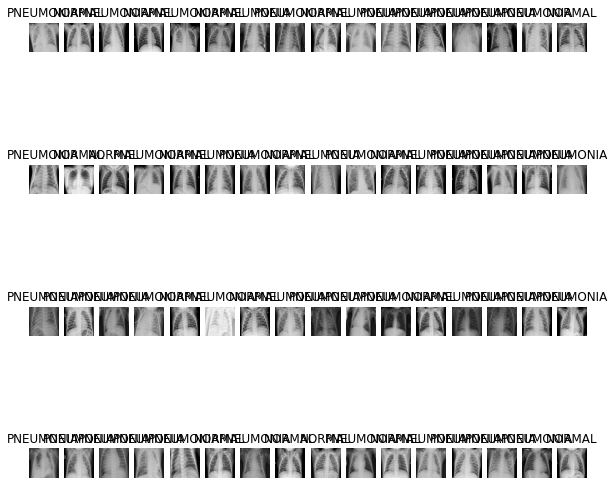

In [15]:
# 이미지 배치확인.
def show_batch(image_batch, label_batch):
    plt.figure(figsize=(10,10))
    for n in range(BATCH_SIZE):
        ax = plt.subplot(4,math.ceil(BATCH_SIZE/4),n+1)
        plt.imshow(image_batch[n])
        if label_batch[n]:
            plt.title("PNEUMONIA")
        else:
            plt.title("NORMAL")
        plt.axis("off")


image_batch, label_batch = next(iter(train_ds))
show_batch(image_batch.numpy(), label_batch.numpy())

In [16]:
# convolution block 만들기
# convolution 두 번 진행하고, Backnormalization, Gradient Vanishing, Gradient Exploding 해결
def conv_block(filters):
    block = tf.keras.Sequential([
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPool2D()
    ])
    
    return block

In [17]:
def dense_block(units, dropout_rate):
    block = tf.keras.Sequential([
        tf.keras.layers.Dense(units, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(dropout_rate)
    ])
    
    return block

In [18]:
def build_model():
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)),
        
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.MaxPool2D(),
        
        conv_block(32),
        conv_block(64),
        
        conv_block(128),
        tf.keras.layers.Dropout(0.2),
        
        conv_block(256),
        tf.keras.layers.Dropout(0.2),
        
        tf.keras.layers.Flatten(),
        dense_block(512, 0.7),
        dense_block(128, 0.5),
        dense_block(64, 0.3),
        
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    
    return model

### 데이터 imbalance 처리

In [19]:
weight_for_0 = (1 / COUNT_NORMAL)*(TRAIN_IMG_COUNT)/2.0 
weight_for_1 = (1 / COUNT_PNEUMONIA)*(TRAIN_IMG_COUNT)/2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for NORMAL: {:.2f}'.format(weight_for_0))
print('Weight for PNEUMONIA: {:.2f}'.format(weight_for_1))

Weight for NORMAL: 1.95
Weight for PNEUMONIA: 0.67


### 모델 훈련

In [20]:
with tf.device('/GPU:0'):
    model = build_model()

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=METRICS
    )

In [21]:
with tf.device('/GPU:0'):
    history = model.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
    )

Epoch 1/32
65/65 [==============================] - 60s 717ms/step - loss: 0.4633 - accuracy: 0.7531 - precision: 0.9484 - recall: 0.7065 - val_loss: 0.5999 - val_accuracy: 0.7363 - val_precision: 0.7363 - val_recall: 1.0000
Epoch 2/32
65/65 [==============================] - 50s 770ms/step - loss: 0.1951 - accuracy: 0.9293 - precision: 0.9785 - recall: 0.9256 - val_loss: 0.7977 - val_accuracy: 0.7363 - val_precision: 0.7363 - val_recall: 1.0000
Epoch 4/32
65/65 [==============================] - 52s 813ms/step - loss: 0.1518 - accuracy: 0.9454 - precision: 0.9818 - recall: 0.9439 - val_loss: 0.9353 - val_accuracy: 0.7354 - val_precision: 0.7354 - val_recall: 1.0000
Epoch 5/32
65/65 [==============================] - 45s 698ms/step - loss: 0.1456 - accuracy: 0.9474 - precision: 0.9809 - recall: 0.9476 - val_loss: 1.0360 - val_accuracy: 0.7363 - val_precision: 0.7363 - val_recall: 1.0000
Epoch 6/32
65/65 [==============================] - 45s 701ms/step - loss: 0.1350 - accuracy: 0.9524

### 결과 확인

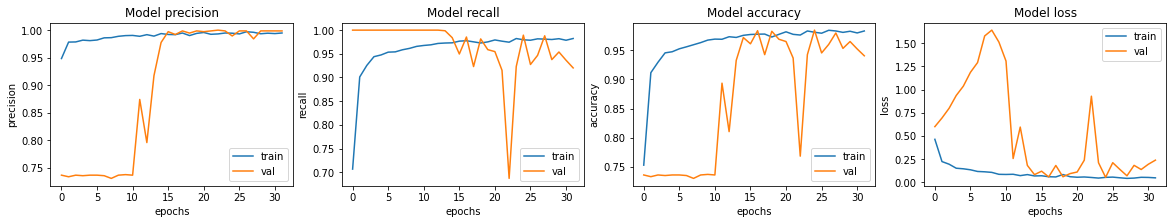

In [22]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [23]:
loss, accuracy, precision, recall = model.evaluate(test_ds)
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

10/10 [==============================] - 4s 434ms/step - loss: 0.5106 - accuracy: 0.8798 - precision: 0.8689 - recall: 0.9513
Loss: 0.5105900168418884,
Accuracy: 0.879807710647583,
Precision: 0.868852436542511,
Recall: 0.9512820243835449


# 회고

## 1. 모델에 대한 평가

이번에 진행한 프로젝트는 정상인의 폐와 폐렴환자의 폐를 이용해 신경망을 학습하여 정확한 얼마나 정확한 진단을 내리는가에 대한 실험이었다. 기존의 노드에서 배치사이즈와 시행횟수를 조정하였다. 또한 노드에서 제시한대로 데이터를 준비하는 과정에서 좌우, 반전 등 보다 다양한 사진에 대해서 잘 진단할 수 있도록 하였다.<br>
정확도는 목표 정확도인 0.85를 넘겨 0.879를 기록하였다. 배치 사이즈는 32, 64, 128, epoch은 25~35 사이의 값으로 반복해서 실험한 결과 사이즈 64, epoch은 32일때 목표치를 달성했다.
<br><br>

한가지 의문이 드는 점은 평가의 기준이 accuracy라는 점이다. <br>
이 예제는 두 번째로 진행했었던 _유방암 진단_ 예제처럼, 정상인의 사진을 두고 폐렴환자라고 판단하는 것에 비하여 폐렴환자의 사진을 두고 폐렴환자라고 판단하는 것이 훨씬 중요하다. <br>즉, __Recall Sensitivity(재현율)__이 매우 중요하다고 할 수 있다. <br>

$$ Recall = \frac{TP} {TP+FN} $$ <br><br>

추가적으로 Epoch에 따른 Accuracy, Precision, Recall 등의 그래프를 살펴보면 정상적으로 작동하다가도 간혹 그래프의 개형이 뾰족한 모습을 띄는 것을 알 수 있는데 이는 'dropout'에 의해 신경망의 연결을 일시적으로 사용하지 않았기 때문으로 보인다.




## 2. 후기

오늘 프로젝트는 비교적 기존에 했던 노드에서 비슷한 노드들이 있어서 아주 어렵지는 않았던 것 같다. 다만 그럼에도 모델의 정확도를 올리는 것 자체는 쉬운일은 아니었다. 특히 적절한 배치사이즈를 선정하는데에 있어 경험에 의한 직관을 통한 것인지 헷갈리는 부분이 많은 것 같다. <br>
또한 dropout에 대해서 제대로 알고 사용한적은 거의 처음이라 더욱 의미있었던 것 같다.